In [24]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

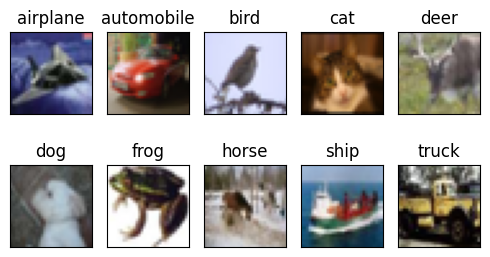

In [28]:
num_classes = len(np.unique(y_train))
label_names = {
    'airplane' : 0 ,
    'automobile' : 1,
    'bird' : 2,
    'cat': 3,
    'deer' : 4,
    'dog' : 5,
    'frog' : 6,
    'horse' : 7,
    'ship' : 8,
    'truck' : 9
}

fig = plt.figure(figsize=(5, 3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    plt.imshow(img)

plt.tight_layout()

In [30]:
latent_dim = 100
input_shape = x_train[0].shape
print(input_shape)

(32, 32, 3)


In [31]:
class DCGAN():
    def __init__(self, input_shape, latent_dim):
        self.img_shape = input_shape
        self.latent_dim = latent_dim

        self.discriminator = self.build_discriminator()

        self.generator = self.build_generator()

        self.gan = self.define_gan()

    def build_generator(self):
        model = models.Sequential(name="Generator")

        n_nodes = 128 * 8 * 8

        model.add(layers.Dense(n_nodes, input_dim=self.latent_dim))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Reshape((8, 8, 128)))

        model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same'))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(3, (5,5), activation='sigmoid', padding='same'))

        model.summary()

        return model

    def build_discriminator(self):
        model = models.Sequential(name="Discriminator")

        model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))

        model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Flatten())

        model.add(layers.Dense(1, activation='sigmoid'))

        model.summary()

        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def define_gan(self):
        self.discriminator.trainable = False
        model = models.Sequential(name="GAN")

        model.add(self.generator)
        model.add(self.discriminator)

        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)

        model.summary()

        return model

    def generate_real_samples(self, dataset, n_samples):
        # choose random images
        ix = np.random.randint(0, dataset.shape[0], n_samples)

        X = dataset[ix]

        y = np.ones((n_samples, 1)) ##Label=1 indicating they are real
        return X, y

    def generate_latent_points(self, latent_dim, n_samples):
        # generate points in the latent space
        x_input = np.random.randn(latent_dim * n_samples)

        x_input = x_input.reshape(n_samples, latent_dim)
        return x_input

    def generate_fake_samples(self, latent_dim, n_samples):

        x_input = self.generate_latent_points(latent_dim, n_samples)
        # predict using generator to generate fake samples.
        X = self.generator.predict(x_input, verbose=0)

        y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
        return X, y



    def train(self, X_train, epochs, batch_size=128, plot_interval=50):
        bat_per_epo = int(X_train.shape[0] / batch_size)
        half_batch = int(batch_size / 2)

        d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []

        metrics = ['d_loss_real', 'd_loss_fake', 'g_loss']

        for epoch in range(epochs):
            print(f"\nEpoch: {epoch+1}/{epochs}")

            progbar = Progbar(bat_per_epo, stateful_metrics=metrics)

            for j in range(bat_per_epo):

                # Train the discriminator on real and fake images, separately (half batch each)
                X_real, y_real = self.generate_real_samples(X_train, half_batch)
                d_loss_real, _ = self.discriminator.train_on_batch(X_real, y_real)

                X_fake, y_fake = self.generate_fake_samples(self.latent_dim, half_batch)
                d_loss_fake, _ = self.discriminator.train_on_batch(X_fake, y_fake)

                X_gan = self.generate_latent_points(self.latent_dim, batch_size)
                y_gan = np.ones((batch_size, 1))

                g_loss = self.gan.train_on_batch(X_gan, y_gan)

                d_loss_real_list.append(d_loss_real)
                d_loss_fake_list.append(d_loss_fake)
                g_loss_list.append(g_loss)

                # Update the existing progress bar with the latest loss values
                values = [('d_loss_real', d_loss_real), ('d_loss_fake', d_loss_fake), ('g_loss', g_loss)]
                progbar.add(1, values=values)

            if (epoch + 1) % plot_interval == 0:
                self.plot_generated_images(10)

        return d_loss_real_list, d_loss_fake_list, g_loss_list

    def plot_generated_images(self, samples=10):
        z = np.random.normal(0, 1, (samples, self.latent_dim))
        x_fake = self.generator.predict(z)
        # Denormalize the generated images
        x_fake = 255 * x_fake
        plt.figure(figsize=(5, 3))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].astype(np.uint8))  # Convert to uint8 for display
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()


In [32]:
dcgan = DCGAN(input_shape, latent_dim)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 4, 4, 256)       


Epoch: 1/60
390/390 [==============================] - 63s 151ms/step - d_loss_real: 0.6904 - d_loss_fake: 0.6943 - g_loss: 0.7228

Epoch: 2/60
390/390 [==============================] - 59s 152ms/step - d_loss_real: 0.6790 - d_loss_fake: 0.6955 - g_loss: 0.7150

Epoch: 3/60
390/390 [==============================] - 57s 147ms/step - d_loss_real: 0.7056 - d_loss_fake: 0.6877 - g_loss: 0.7268

Epoch: 4/60
390/390 [==============================] - 58s 148ms/step - d_loss_real: 0.6933 - d_loss_fake: 0.6699 - g_loss: 0.7349

Epoch: 5/60
1/1 [==============================] - 0s 91ms/step


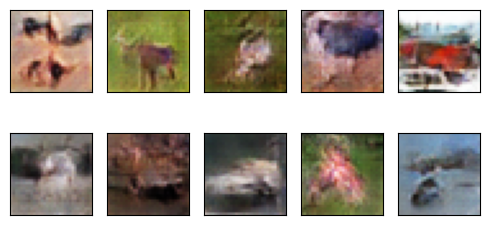


Epoch: 6/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.7042 - d_loss_fake: 0.6875 - g_loss: 0.7275

Epoch: 7/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.6901 - d_loss_fake: 0.6899 - g_loss: 0.7202

Epoch: 8/60
390/390 [==============================] - 57s 146ms/step - d_loss_real: 0.7146 - d_loss_fake: 0.7048 - g_loss: 0.7112

Epoch: 9/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.6840 - d_loss_fake: 0.7058 - g_loss: 0.7077

Epoch: 10/60
1/1 [==============================] - 0s 17ms/step


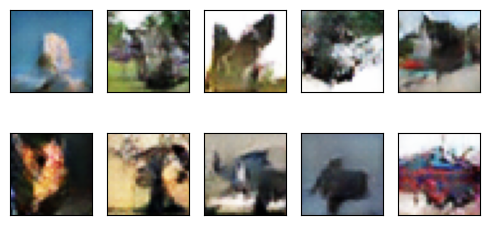


Epoch: 11/60
390/390 [==============================] - 60s 154ms/step - d_loss_real: 0.6966 - d_loss_fake: 0.6804 - g_loss: 0.7181

Epoch: 12/60
390/390 [==============================] - 59s 150ms/step - d_loss_real: 0.6754 - d_loss_fake: 0.6715 - g_loss: 0.7431

Epoch: 13/60
390/390 [==============================] - 60s 154ms/step - d_loss_real: 0.6716 - d_loss_fake: 0.6989 - g_loss: 0.7248

Epoch: 14/60
390/390 [==============================] - 60s 154ms/step - d_loss_real: 0.6737 - d_loss_fake: 0.6939 - g_loss: 0.7279

Epoch: 15/60
1/1 [==============================] - 0s 19ms/step


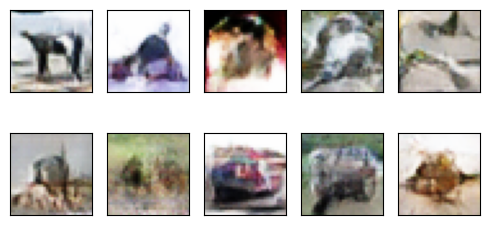


Epoch: 16/60
390/390 [==============================] - 58s 149ms/step - d_loss_real: 0.6623 - d_loss_fake: 0.6938 - g_loss: 0.7184

Epoch: 17/60
390/390 [==============================] - 61s 156ms/step - d_loss_real: 0.6853 - d_loss_fake: 0.6719 - g_loss: 0.7238

Epoch: 18/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.6973 - d_loss_fake: 0.6761 - g_loss: 0.7593

Epoch: 19/60
390/390 [==============================] - 58s 149ms/step - d_loss_real: 0.6866 - d_loss_fake: 0.6687 - g_loss: 0.7326

Epoch: 20/60
1/1 [==============================] - 0s 20ms/step


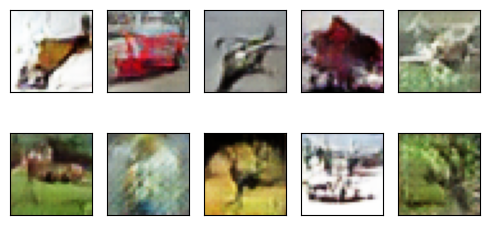


Epoch: 21/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.6858 - d_loss_fake: 0.6760 - g_loss: 0.7179

Epoch: 22/60
390/390 [==============================] - 60s 153ms/step - d_loss_real: 0.6812 - d_loss_fake: 0.6782 - g_loss: 0.7370

Epoch: 23/60
390/390 [==============================] - 61s 157ms/step - d_loss_real: 0.6667 - d_loss_fake: 0.6942 - g_loss: 0.7244

Epoch: 24/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.6845 - d_loss_fake: 0.6850 - g_loss: 0.7349

Epoch: 25/60
1/1 [==============================] - 0s 22ms/step


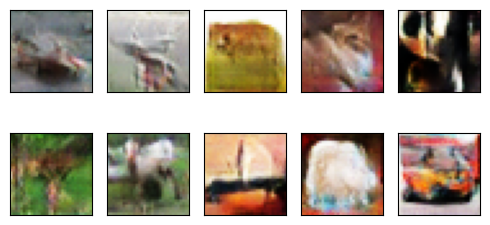


Epoch: 26/60
390/390 [==============================] - 59s 151ms/step - d_loss_real: 0.7002 - d_loss_fake: 0.6790 - g_loss: 0.7298

Epoch: 27/60
390/390 [==============================] - 58s 148ms/step - d_loss_real: 0.6805 - d_loss_fake: 0.6794 - g_loss: 0.7278

Epoch: 28/60
390/390 [==============================] - 64s 165ms/step - d_loss_real: 0.6985 - d_loss_fake: 0.6814 - g_loss: 0.7579

Epoch: 29/60
390/390 [==============================] - 59s 150ms/step - d_loss_real: 0.6953 - d_loss_fake: 0.6882 - g_loss: 0.7448

Epoch: 30/60
1/1 [==============================] - 0s 17ms/step


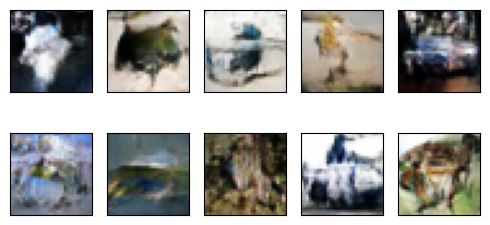


Epoch: 31/60
390/390 [==============================] - 61s 157ms/step - d_loss_real: 0.6866 - d_loss_fake: 0.6649 - g_loss: 0.7415

Epoch: 32/60
390/390 [==============================] - 59s 150ms/step - d_loss_real: 0.7029 - d_loss_fake: 0.6740 - g_loss: 0.7395

Epoch: 33/60
390/390 [==============================] - 61s 156ms/step - d_loss_real: 0.6941 - d_loss_fake: 0.6615 - g_loss: 0.7462

Epoch: 34/60
390/390 [==============================] - 60s 155ms/step - d_loss_real: 0.6896 - d_loss_fake: 0.6724 - g_loss: 0.7413

Epoch: 35/60
1/1 [==============================] - 0s 18ms/step


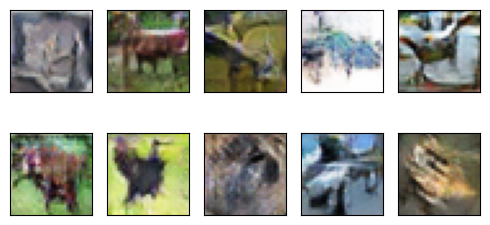


Epoch: 36/60
390/390 [==============================] - 63s 160ms/step - d_loss_real: 0.6782 - d_loss_fake: 0.6786 - g_loss: 0.7231

Epoch: 37/60
390/390 [==============================] - 60s 154ms/step - d_loss_real: 0.6661 - d_loss_fake: 0.7021 - g_loss: 0.7298

Epoch: 38/60
390/390 [==============================] - 59s 152ms/step - d_loss_real: 0.6860 - d_loss_fake: 0.6546 - g_loss: 0.7479

Epoch: 39/60
390/390 [==============================] - 64s 165ms/step - d_loss_real: 0.6616 - d_loss_fake: 0.6782 - g_loss: 0.7607

Epoch: 40/60
1/1 [==============================] - 0s 19ms/step


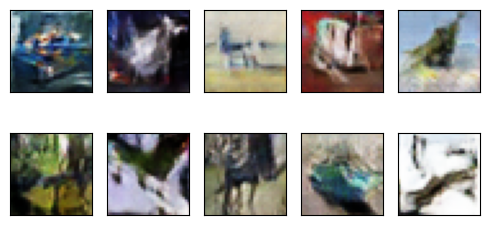


Epoch: 41/60
390/390 [==============================] - 62s 159ms/step - d_loss_real: 0.6556 - d_loss_fake: 0.7085 - g_loss: 0.7409

Epoch: 42/60
390/390 [==============================] - 63s 161ms/step - d_loss_real: 0.6978 - d_loss_fake: 0.7049 - g_loss: 0.7480

Epoch: 43/60
390/390 [==============================] - 62s 160ms/step - d_loss_real: 0.6653 - d_loss_fake: 0.6564 - g_loss: 0.7538

Epoch: 44/60
390/390 [==============================] - 63s 160ms/step - d_loss_real: 0.6733 - d_loss_fake: 0.6737 - g_loss: 0.7499

Epoch: 45/60
1/1 [==============================] - 0s 19ms/step


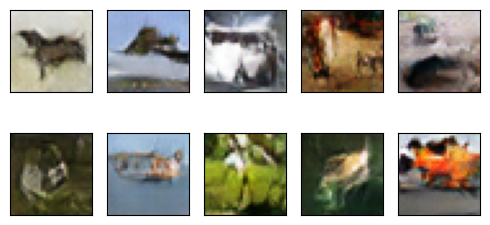


Epoch: 46/60
390/390 [==============================] - 61s 156ms/step - d_loss_real: 0.6499 - d_loss_fake: 0.6912 - g_loss: 0.7443

Epoch: 47/60
390/390 [==============================] - 64s 165ms/step - d_loss_real: 0.6745 - d_loss_fake: 0.6752 - g_loss: 0.7503

Epoch: 48/60
390/390 [==============================] - 63s 161ms/step - d_loss_real: 0.6843 - d_loss_fake: 0.6911 - g_loss: 0.7612

Epoch: 49/60
390/390 [==============================] - 60s 154ms/step - d_loss_real: 0.7068 - d_loss_fake: 0.6741 - g_loss: 0.7704

Epoch: 50/60
1/1 [==============================] - 0s 20ms/step


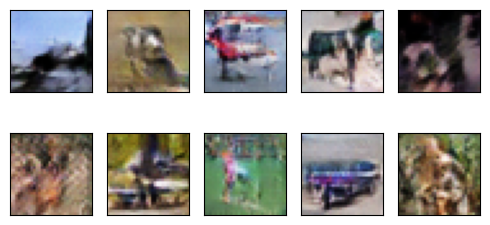


Epoch: 51/60
390/390 [==============================] - 62s 160ms/step - d_loss_real: 0.6629 - d_loss_fake: 0.6558 - g_loss: 0.7586

Epoch: 52/60
390/390 [==============================] - 63s 161ms/step - d_loss_real: 0.6976 - d_loss_fake: 0.6784 - g_loss: 0.7722

Epoch: 53/60
390/390 [==============================] - 64s 165ms/step - d_loss_real: 0.6860 - d_loss_fake: 0.6826 - g_loss: 0.7394

Epoch: 54/60
390/390 [==============================] - 61s 156ms/step - d_loss_real: 0.6792 - d_loss_fake: 0.6859 - g_loss: 0.7580

Epoch: 55/60
1/1 [==============================] - 0s 22ms/step


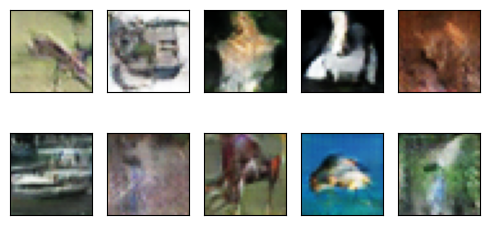


Epoch: 56/60
390/390 [==============================] - 64s 163ms/step - d_loss_real: 0.6750 - d_loss_fake: 0.6840 - g_loss: 0.7441

Epoch: 57/60
390/390 [==============================] - 63s 160ms/step - d_loss_real: 0.6872 - d_loss_fake: 0.6534 - g_loss: 0.7354

Epoch: 58/60
390/390 [==============================] - 66s 169ms/step - d_loss_real: 0.6784 - d_loss_fake: 0.6255 - g_loss: 0.8029

Epoch: 59/60
390/390 [==============================] - 62s 160ms/step - d_loss_real: 0.6589 - d_loss_fake: 0.6685 - g_loss: 0.7500

Epoch: 60/60
1/1 [==============================] - 0s 22ms/step


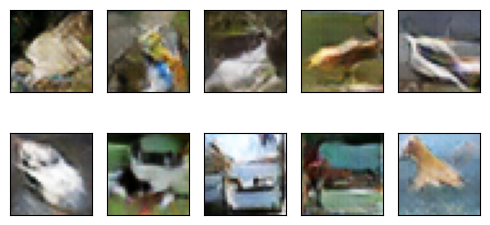

In [34]:
d_loss_real_list, d_loss_fake_list, g_loss_list =  dcgan.train(x_train, epochs=60, batch_size=128, plot_interval=5)

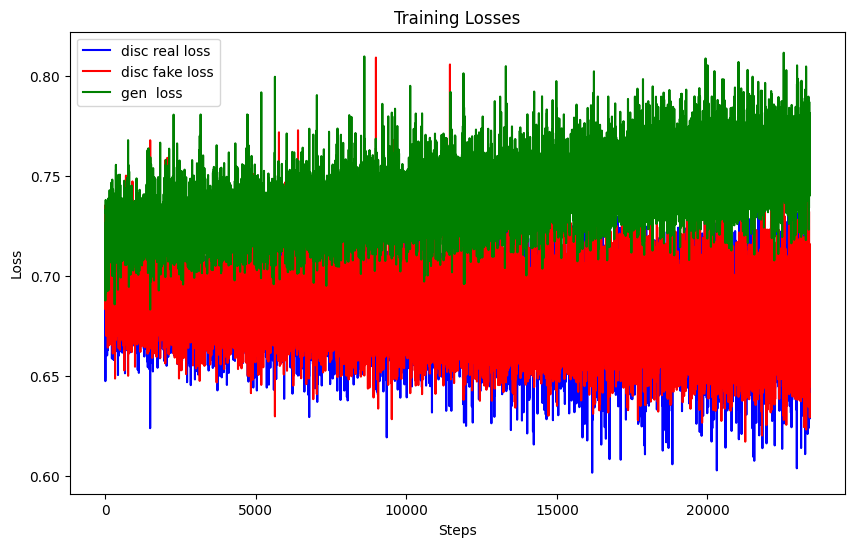

In [36]:
# Plot the losses
epochs = range(1, len(d_loss_real_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, d_loss_real_list, 'b', label='disc real loss')
plt.plot(epochs, d_loss_fake_list, 'r', label='disc fake loss')
plt.plot(epochs, g_loss_list, 'g', label='gen  loss')
plt.title('Training Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()